In [1]:
import sys 
import os  
import json
import datetime as dt 
import pandas as pd 
import numpy as np 
import bottleneck as bn 
import talib 
import tulipy
import sqlite3 as sql
from itertools import repeat
from p_tqdm import p_umap
import matplotlib as plt 
sys.path.append('../')
from backtester import * 
from fxcmtoken import my_assets

In [2]:
for i, v in enumerate(my_assets): print(i, v)

0 EUR/USD
1 USD/JPY
2 GBP/USD
3 USD/CHF
4 AUD/USD
5 USD/CAD
6 NZD/USD
7 Bund
8 AUS200
9 ESP35
10 EUSTX50
11 FRA40
12 GER30
13 HKG33
14 JPN225
15 NAS100
16 SPX500
17 UK100
18 US30
19 Copper
20 NGAS
21 UKOil
22 USOil
23 XAU/USD
24 XAG/USD


In [22]:
n_period = 200
freq = 'm5'
# sql_path = f'../PriceData/PriceData_{freq}.db'
sql_path = f'/home/kachain/python_projects/algorithmic_trading/PriceData/PriceData_{freq}.db'
    
conn = sql.connect(sql_path)
ticker = my_assets[24]
print(ticker, n_period)
data_sql = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
for col in ['open', 'close', 'high', 'low']:
    data_sql[col] = data_sql[['bid'+col, 'ask'+col]].mean(axis=1)
conn.close()

XAG/USD 200


  0%|          | 0/9402 [00:00<?, ?it/s]

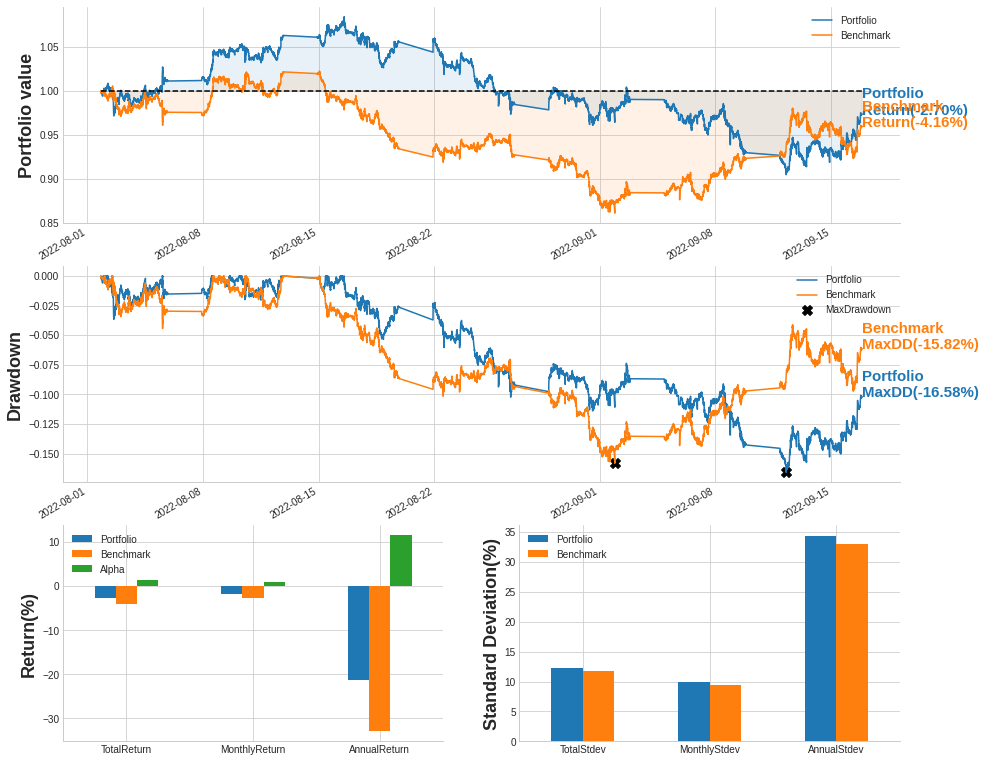

----------------------------------------------------------------------
Data length: |46 days 01:10:00|
Data range from |2022-08-01 19:35:00| to |2022-09-16 20:45:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -2.700 │      -4.160 │   1.461 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -1.759 │      -2.710 │   0.952 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │     -21.399 │     -32.975 │  11.577 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [19]:
data_sql = data_sql.assign(avgprice=lambda x: talib.AVGPRICE(x.open, x.high, x.low, x.close),
                           medprice=lambda x: talib.MEDPRICE(x.high, x.low),
                           typprice=lambda x: talib.TYPPRICE(x.high, x.low, x.close),
                           wclprice=lambda x: talib.WCLPRICE(x.high, x.low, x.close))
data_sql = data_sql.assign(dema=lambda x: talib.DEMA(x.medprice, n_period),
                           tema=lambda x: talib.TEMA(x.medprice, n_period),
                           signal=lambda x: bn.push(np.where(x.tema > x.dema, 1, np.where(x.tema < x.dema, -1, np.nan)), axis=0))
data_sql.dropna(axis=0, inplace=True)

data = data_sql[['bidopen', 'bidclose', 'bidhigh', 'bidlow',
                 'askopen', 'askclose', 'askhigh', 'asklow',
                 'tickqty']]
signal = data_sql.signal

backtester = IterativeBacktester(data, signal, freq)
backtester.backtest()
backtester.results()

In [23]:
data_sql

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,close,high,low
date,,,,,,,,,,,,,
2022-07-28 15:50:00,19.851,19.805,19.856,19.805,19.883,19.837,19.889,19.837,383,19.8670,19.8210,19.8725,19.8210
2022-07-28 15:55:00,19.804,19.778,19.820,19.773,19.837,19.811,19.852,19.804,477,19.8205,19.7945,19.8360,19.7885
2022-07-28 16:00:00,19.776,19.782,19.782,19.745,19.808,19.814,19.815,19.777,530,19.7920,19.7980,19.7985,19.7610
2022-07-28 16:05:00,19.782,19.774,19.789,19.763,19.815,19.807,19.821,19.796,377,19.7985,19.7905,19.8050,19.7795
2022-07-28 16:10:00,19.773,19.775,19.783,19.763,19.806,19.807,19.816,19.795,356,19.7895,19.7910,19.7995,19.7790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-16 20:25:00,19.528,19.542,19.545,19.528,19.559,19.576,19.578,19.559,67,19.5435,19.5590,19.5615,19.5435
2022-09-16 20:30:00,19.542,19.546,19.546,19.540,19.577,19.580,19.582,19.576,40,19.5595,19.5630,19.5640,19.5580
2022-09-16 20:35:00,19.544,19.558,19.563,19.539,19.580,19.593,19.601,19.573,61,19.5620,19.5755,19.5820,19.5560


In [2]:
def get_strategy_return(data_sql, n_period, freq):    
  
    data_sql = data_sql.assign(
        medprice=lambda x: talib.MEDPRICE(x.high, x.low),
        dema=lambda x: talib.DEMA(x.medprice, n_period),
        tema=lambda x: talib.TEMA(x.medprice, n_period),
        signal=lambda x: bn.push(np.where(x.tema > x.dema, 1, np.where(x.tema < x.dema, -1, np.nan)), axis=0)
    )
    data_sql.dropna(axis=0, inplace=True)
    data = data_sql[['bidopen', 'bidclose', 'bidhigh', 'bidlow',
                     'askopen', 'askclose', 'askhigh', 'asklow',
                     'tickqty']]
    signal = data_sql.signal
    backtester = IterativeBacktester(data=data, signals=signal, freq=freq)
    backtester.backtest(progress_bar=False)

    return n_period, backtester.return_df.loc['MonthlyReturn', 'Portfolio'], backtester.ratio_df.loc['Portfolio', 'MaxDrawdown(%)']

In [3]:
def get_optim_param(ticker, freq, params): 
    sql_path = f'/home/kachain/python_projects/algorithmic_trading/PriceData/PriceData_{freq}.db'
    conn = sql.connect(sql_path)
    data_sql = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
    for col in ['open', 'close', 'high', 'low']:
        data_sql[col] = data_sql[['bid'+col, 'ask'+col]].mean(axis=1)
    conn.close()
    
    res = p_umap(get_strategy_return, repeat(data_sql.copy(deep=True)), params, repeat(freq))
    res_df = pd.DataFrame(res, columns=['n_periods', 'returns', 'maxdd'])
    res_df.sort_values(by=['returns', 'maxdd'], ascending=False, inplace=True)
    res_df.reset_index(drop=True, inplace=True)
    
    return res_df

In [20]:
def plot_parameters(res_df):
    best_n = res_df.n_periods[0]
    fig, ax = plt.subplots(2, 1, figsize=(15,8))

    ax[0].scatter(res_df.n_periods, res_df.returns, color='tab:blue')
    ax[0].set_ylabel('returns', fontsize=14)
    ax[0].axhline(y=0, color='k', linestyle='--')
    ax[0].axvline(x=best_n, color='r', linestyle='--')

    ax[1].scatter(res_df.n_periods, res_df.maxdd, color='tab:orange', marker='^')
    ax[1].set_ylabel('maxdd', fontsize=14)
    ax[1].axvline(x=best_n, color='r', linestyle='--')
    
    fig.tight_layout()
    plt.show()

In [5]:
for i, v in enumerate(my_assets): print(i, v)

0 EUR/USD
1 USD/JPY
2 GBP/USD
3 USD/CHF
4 AUD/USD
5 USD/CAD
6 NZD/USD
7 Bund
8 AUS200
9 ESP35
10 EUSTX50
11 FRA40
12 GER30
13 HKG33
14 JPN225
15 NAS100
16 SPX500
17 UK100
18 US30
19 Copper
20 NGAS
21 UKOil
22 USOil
23 XAU/USD
24 XAG/USD


In [22]:
params = [i for i in range(5, 501, 5)]
print(params)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500]


In [ ]:
ticker = my_assets[8]
freq = 'm5'

print(ticker, freq)
res = get_optim_param(ticker, freq, params)

AUS200 m5


  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
res

,n_periods,returns,maxdd
0,95,0.018844,-5.949675
1,90,0.018651,-5.881418
2,75,0.017923,-3.803677
3,80,0.015013,-4.578365
4,100,0.014805,-7.686170
...,...,...,...
95,275,-0.067803,-16.104819
96,20,-0.084684,-21.180824
97,15,-0.087152,-22.299900
98,10,-0.146970,-33.170591


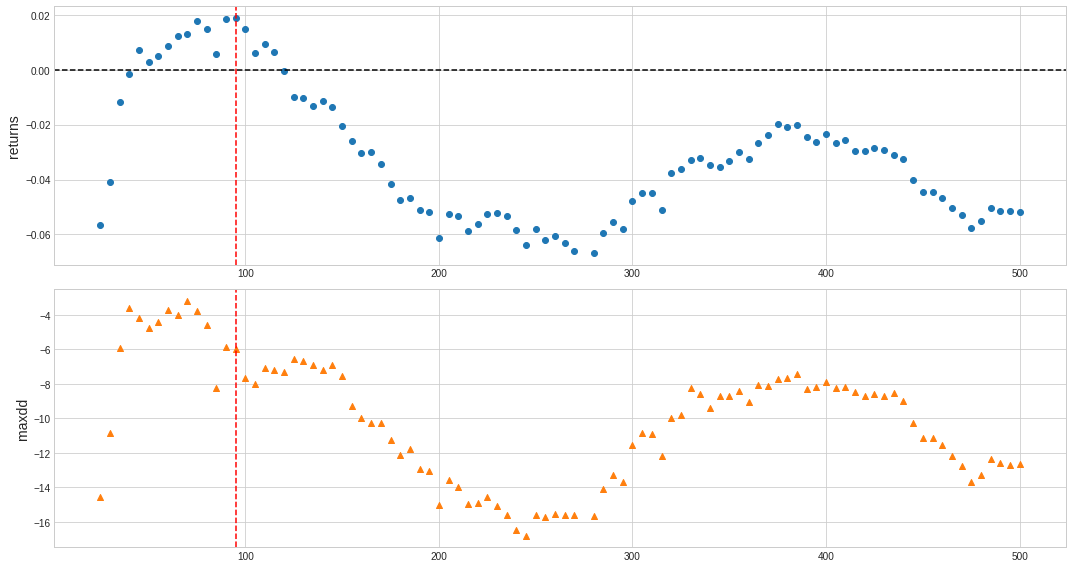

In [41]:
plot_parameters(res.iloc[:-5])